# 영화 리뷰 감성분석

## 리뷰 csv에 크롤링

In [1]:
# read로 불러오면 자동으로 인덱스가 추가된다. 이러면 매우매우 복잡해진다. 가능하면 같은 창에서 크롤링이랑 감성분석까지 해버리자

import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:


#1791
reviews=[]
for i in range(1,51):

    url='https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=208077&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page='+str(i)
    res=requests.get(url)
    soup=BeautifulSoup(res.text, 'lxml')
    divs=soup.find_all('div', attrs={'class':'score_reple'})
    
    for div in divs:
        spans=div.find_all('span')
        
        if spans[0].get_text()=='스포일러가 포함된 감상평입니다. 감상평 보기'or spans[1].get_text()=='스포일러가 포함된 감상평입니다. 감상평 보기':
            continue
        
        if spans[0].get_text()=='관람객':
            review=spans[1].get_text()
        else:
            review=spans[0].get_text()
        
        review=review.strip()
        reviews.append(review) # reviews= reviews.append(review) 이렇게 하면 에러난다
    
datas=pd.Series(reviews)
datas.to_csv('reviews.csv', encoding='utf-8-sig', index=False)

In [3]:
print(len(datas)) # 셀 개수 확인

430


## nan 값(빈칸인 리뷰) 제거

In [4]:
datas.replace("",np.nan, inplace=True)
print(datas.isna().sum()) # nan 값 인거 체크
datas=datas.dropna(how='any') # 해당 셀 제거
print(datas.isnull().values.any()) # 제거 됐는지 확인
print(len(datas)) # 셀 개수 다시 확인


1
False
429


## 데이터 전처리

In [5]:
# 한글만 남기고 전부 삭제
datas=datas.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
datas[:10]


C:\Users\김원교\AppData\Local\Temp/ipykernel_19348/3102185231.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  datas=datas.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")


0                                    삼십대의내가십대이십대의나를만났다
1                                 스파이더맨부터본사람이면재미없을수가없다
2                전스파이더맨두명이자책했던일들이여기서어느정도구원받았다는거에감사드립니다
3                    엔드게임을뛰어넘는영화가죽기전에나올까생각했었는데년만에나왔습니다
4                                        마블이준비한크리스마스선물
5                               세기가장최고의소리어벤져스이후마블영화는안봄
6    닥터옥토버스가토비에게다컸구나잘지냈니는어린시절스파이더맨보고자란사람들에게하는말같았고토비...
7                                       개인적으로그린고블린이살렸다
8                                      가능하면여분의팬티를챙겨가세요
9                                             암세포도생명이다
dtype: object

In [6]:
# 원래 한글이 없는 데이터는 공백이 됐을 것임
datas = datas.str.replace('^ +', "") # 공백(withespace)인 데이터를 empty value로 변경
datas.replace('', np.nan, inplace=True) # empty value를 nan 값으로 변경
print(datas.isnull().sum())
datas=datas.dropna(how='any') # nan 셀 삭제
print(len(datas)) # 삭제됐나 확인

1
428


C:\Users\김원교\AppData\Local\Temp/ipykernel_19348/568378091.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  datas = datas.str.replace('^ +', "") # 공백(withespace)인 데이터를 empty value로 변경


## 토큰화

In [7]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [8]:
okt=Okt()
datas_morphs=[] # 리뷰 목록 리스트의 리뷰들을 형태소 별로 분석한  형태소 리스트
for data in datas:
    tokenized_data=okt.morphs(data,stem=True) # 형태소 별로 토큰화
    stopwords_removed_data=[word for word in tokenized_data if not word in stopwords] # 불용어 정제
    datas_morphs.append(stopwords_removed_data) # 불용어 정제한 형태소들 리스트에 추가


## 정수 인코딩

In [9]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(datas_morphs) # 단어 집합 생성 + 각 단어에 고유한 정수 부여
print(tokenizer.word_index) # word_index로 확인가능, 숫자는 빈도수 높은 순으로 감

{'스파이더맨': 1, '영화': 2, '보다': 3, '을': 4, '마블': 5, '이다': 6, '팬': 7, '최고': 8, '선물': 9, '진짜': 10, '되다': 11, '다': 12, '너무': 13, '같다': 14, '로': 15, '시리즈': 16, '재밌다': 17, '사람': 18, '좋다': 19, '감동': 20, '있다': 21, '없다': 22, '하': 23, '모든': 24, '그': 25, '중': 26, '에서': 27, '만': 28, '위': 29, '말': 30, '정말': 31, '부터': 32, '크다': 33, '에게': 34, '적': 35, '까지': 36, '내': 37, '안': 38, '눈물': 39, '대': 40, '본': 41, '정도': 42, '년': 43, '미치다': 44, '피터': 45, '면': 46, '오다': 47, '생각': 48, '보고': 49, 'ㅠㅠ': 50, '그냥': 51, '엔드게임': 52, '나': 53, '스토리': 54, '좋아하다': 55, '톰': 56, '역대': 57, '나오다': 58, '사랑': 59, '것': 60, '들다': 61, '아니다': 62, '라면': 63, '지': 64, '아': 65, '가다': 66, '오랜': 67, '히어로': 68, '그리고': 69, '급': 70, '종합': 71, '꼭': 72, '야하다': 73, '느끼다': 74, '받다': 75, '스포': 76, '이영화': 77, '이렇게': 78, '기대하다': 79, '힘': 80, '올해': 81, '게': 82, '작품': 83, '세트': 84, '파커': 85, '고': 86, '추억': 87, '때': 88, '더': 89, '크리스마스': 90, '않다': 91, '느낌': 92, '점': 93, '만들다': 94, '개': 95, '인생': 96, '또': 97, '홀랜드': 98, '어벤져스': 99, '자다': 100, '완벽하다': 101

## 빈도수 작은 단어 삭제 

In [10]:
threshold=3 #한계점
total_cnt=len(tokenizer.word_index) # 전체 단어 수
rare_cnt=0 # 한계점보다 작은 단어의 수
total_freq=0 # 전체 단어 빈도수
rare_freq=0 # 한계점보다 작은 단어들의 빈도수

In [11]:
# 3회 이하의 빈도를 가진 단어의 수와 빈도 확인 > 단어 수는 많지만 빈도수는 적단 걸 알 수 있음
for key, value in tokenizer.word_counts.items(): # word._counts는 빈도수대로 정렬한 단어의 빈도수를 나타낸다
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 한계점보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('전체 단어수 :',total_cnt)
print('등장 빈도수가 %s번 이하인 단어들의 빈도수: %s'%(threshold - 1, rare_cnt))
print("전체 단어수에서 힌계점보다 작은 빈도수를 가진 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 단어 빈도수에서 한계점 이하 단어의 등장 빈도수 비율:", (rare_freq / total_freq)*100)

전체 단어수 : 1472
등장 빈도수가 2번 이하인 단어들의 빈도수: 1110
전체 단어수에서 힌계점보다 작은 빈도수를 가진 단어의 비율: 75.40760869565217
전체 단어 빈도수에서 한계점 이하 단어의 등장 빈도수 비율: 28.286260352516457


In [12]:
# 단어빈도수가 2이하인 단어 제거
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

tokenizer=Tokenizer(vocab_size) # 등장 빈도수가 3이상인 것으로 리스트 크기를 제한(빈도수 높은 것부터 받는다)
tokenizer.fit_on_texts(datas_morphs)
datas_morphs=tokenizer.texts_to_sequences(datas_morphs) # 텍스트 시퀸스 > 정수 시퀸스

print(datas_morphs[:20])
print(len(datas_morphs))

단어 집합의 크기 : 363
[[196, 37, 40, 196], [1, 32, 41, 18, 46, 256, 22], [128, 1, 197, 113, 42, 75, 257], [52, 4, 258, 2, 259, 47, 48, 43, 260, 58], [5, 90, 9], [198, 8, 99, 261, 5, 2], [153, 33, 100, 262, 263, 1, 49, 18, 34, 14, 153, 37, 13, 199], [154, 35, 264], [], [6], [155, 200, 54, 11, 25, 200, 156, 46, 4, 29], [201, 1, 7, 4, 9, 14, 2, 50], [129, 1, 4, 59, 130], [76, 3, 154, 35, 77, 52], [114, 38, 259, 202], [265, 157, 1, 200, 6, 32, 1, 4, 55, 55, 266, 22, 1, 4, 59, 23, 18, 267, 203, 64, 91], [56, 1, 78, 158, 101, 42, 15, 54, 19, 204, 56, 102], [10, 205, 159, 49, 37, 103, 15, 24, 1], [65, 79, 66, 206, 258, 160], [1, 52]]
428


## 빈 리스트 제거

In [13]:
# Tokenizer(vocab_size)에서 크기를 제한했기 때문에 빈 리스트가 생긴다 > numpy함수를 이용한다
null_morphs=[index for index, data_morphs in enumerate(datas_morphs) if len(data_morphs)<1] # 빈 리스트가 있는지 조건을 걸고 인덱스 추출
datas_morphs = np.delete(datas_morphs, null_morphs, axis=0)
print(len(datas_morphs))

424


C:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## 패딩

리뷰의 최대 길이 : 31
리뷰의 평균 길이 : 7.964622641509434


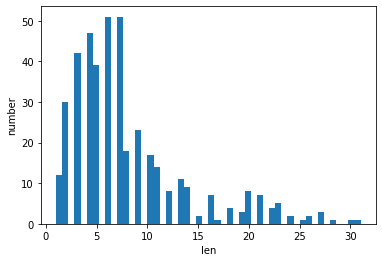

In [17]:
# 최대 길이랑 평균길이 시각화
print('리뷰의 최대 길이 :',max(len(data_morphs) for data_morphs in datas_morphs))
print('리뷰의 평균 길이 :',sum(map(len, datas_morphs))/len(datas_morphs))

plt.hist([len(data_morphs) for data_morphs in datas_morphs], bins=50)
plt.xlabel('len')
plt.ylabel('number')
plt.show()

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
datas_morphs = pad_sequences(datas_morphs, maxlen=20) # 20으로 패딩